In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram , linkage, cut_tree
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
# Reac the csv file
df = pd.read_csv('DATA_2.01_SKU.csv')

# Show the first five rows
df.head()

,ADS,CV
0,1,0.68
1,3,0.40
2,1,0.59
3,2,0.39
4,9,0.11


In [4]:
# Structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADS     100 non-null    int64  
 1   CV      100 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [5]:
# Summary statistics of each numeric variable
df.describe()

,ADS,CV
count,100.000000,100.000000
mean,5.610000,0.396000
std,4.211324,0.237317
min,1.000000,0.050000
25%,2.000000,0.130000
50%,3.000000,0.400000
75%,10.000000,0.590000
max,14.000000,0.960000


# Visual Clustering

Let's try to visually  discern clusters in this small dataset and later see if we obtain the same results with a more systematic apporach.

Text(0.75, 1.8, 'Crickets')

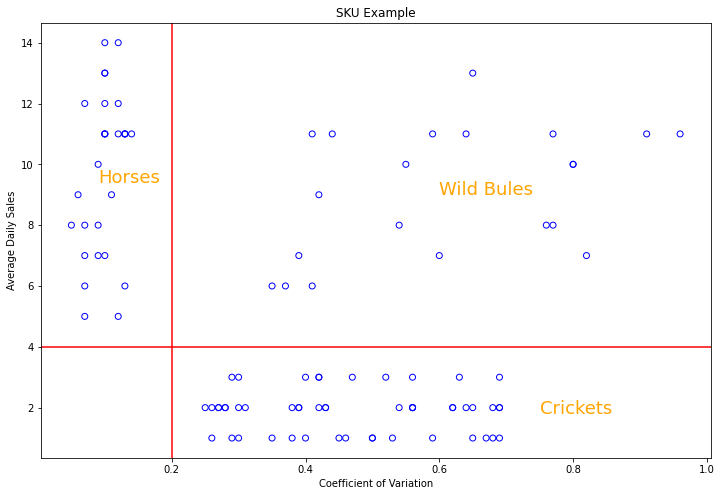

In [6]:
# Scatter plot of the data with group separation lines
#plt.figure(figsize=(12,8))
plt.scatter(df['CV'], df['ADS'], facecolors='none', edgecolors='b', )

plt.title('SKU Example')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Average Daily Sales')

# Vertical line
plt.axvline(x=.2, color='r') 
# Horizontal line
plt.axhline(y=4, color='r')

# We can add some text to our plot by using text()
fsize = 18
col = 'orange'
plt.text(0.09, 9.4, "Horses", color=col, fontsize=fsize)
plt.text(0.6, 9, "Wild Bules", color=col, fontsize=fsize)
plt.text(0.75, 1.8, "Crickets", color=col, fontsize=fsize)

# Hierachical Cluster Analysis (HCA)

## Clustering

Let's find groups using hierarchical clustering and check if we obtain similar results

In [7]:
# copy the dataframe
testdata = df.copy() # deep is set as default

In [8]:
# Scale it
testdata = scale(testdata)

In [9]:
# the pdist() function computes the distances of all the observations 
# in our dataset
d = pdist(testdata) # default metric is euclidean

In [10]:
# Perform hierarchical clustering on distance metrics
# Somehow the ward method didn't return the same result as R
# the default method is 'ward', it never hurts to play around
# with the other common linkage methods. Like in this case the 'weighted'
# delivered better results.
hcward = linkage(d, method='weighted')

## The Dendrogram

Text(0, 0.5, 'Distance')

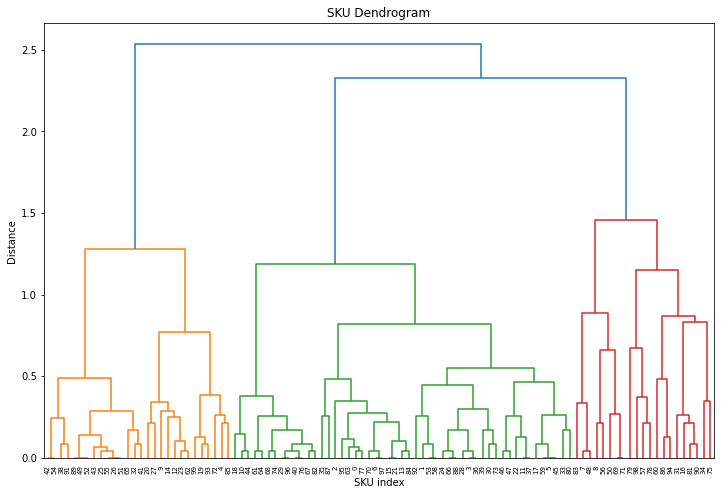

In [11]:
# Plot dendrogram
plt.title("SKU Dendrogram")
dend = dendrogram(hcward,  
                  leaf_rotation=90,
                    leaf_font_size=7);
plt.xlabel('SKU index')
plt.ylabel('Distance')
# Horizontal lines are cluster merges. Their heights tell you about 
# the distance covered for merging then next closest cluster to form a new one.

In this example we have only 100 observations. 
In case of a bigger dataset we could truncate the results and show only the last p merged clusters.

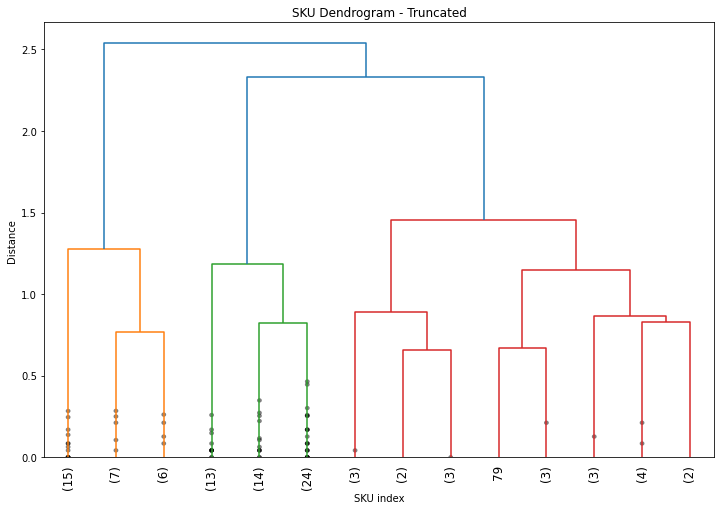

In [12]:
# Plotting a more clear dendrogram
plt.title("SKU Dendrogram - Truncated")
dend = dendrogram(hcward,  
                  truncate_mode='lastp',
                  p = 14,
                  show_contracted=True,
                  leaf_rotation=90,
                  leaf_font_size=12)
plt.xlabel('SKU index')
plt.ylabel('Distance');

The parameter show_contracted allows us to draw black dots at the heights of those previous cluster merges.
 
The cluster size of the truncated clusters is printed in brackets.

## Determining the number of clusters

When it comes to cut-off selection there is no golden method on how to pick the perfect number of clusters. What matters is to use the right clustering approach for the business problem at hand and that your conclusions are actionable. However there is tradeoff between too many nuances and too few:
* Select too many clusters and you will confuse and lose your audience
* Too few and your audience  my over-generalize your results.
In this example we could see from our precedent scatter plot that we have 3 distinctive clusters.

If the number of clusters is not that obvious we could make use of some automated cut-off selection such as the [Elbow Method](https://bit.ly/3exFxim).

☞ For more information about determining the number of cluster check out the following [link](https://bit.ly/3xyJoVg)

## Capture the Clusters

In [13]:
# 3 Clusters
df['groups'] = cut_tree(hcward, n_clusters=3)

## Visualizing Your Clusters

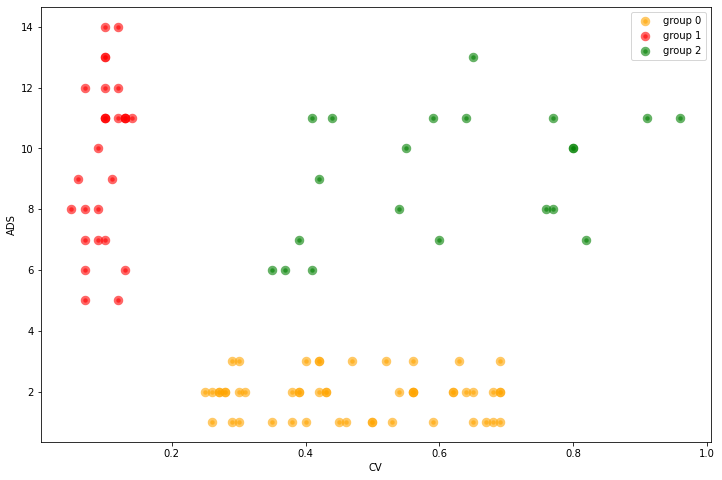

In [14]:
fig, ax = plt.subplots()
col = ['orange', 'red', 'green']

grouped = df.groupby('groups')
for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='CV', 
                   y='ADS', label='group ' + str(key), 
                   linewidths=5, color=col[key],alpha=.6)

Where 
* ADS = Average day sales and 
* CV = Coefficient of Variation or volatility.

The volatility of something may be measured with the coefficient of variation. In this case, it is the standard deviation of sales, divided by the mean sales for the corresponding SKU.

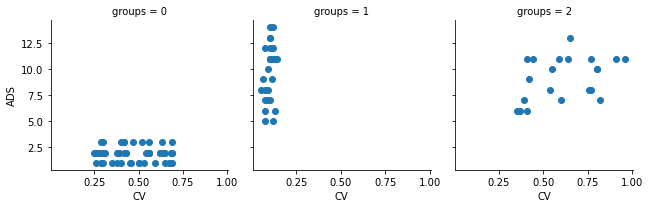

In [15]:
grid1 = sns.FacetGrid(df, col='groups')
grid1.map(plt.scatter, 'CV', 'ADS');

Now that we got the groups, we need to be able to express the complexity of the results in simple terms.



In [16]:
# Let's generate a table with the defined groups
sku_groups = df.groupby('groups').mean()
sku_groups.sort_values(by='ADS', ascending=False)

,ADS,CV
groups,,
1,9.750000,0.099286
2,9.142857,0.616667
0,1.882353,0.468039


# Analysis, Communication and (actionable) Conclusions

Once we get the result with the different clusters, it is crucial to understand what they mean, how do they differ and give them understandable names. So let's do this.

From the above table and figures we recognize that:

1. Group 1: has high sales and low volatility. Let's call them "horses" since those products are strong and reliable
2. Group 2 has also high sales but also high volatility. Let's call them "bulls", since they are strong, but difficult to control.
3. Group 0: we name the group of low sales and high volatility "crickets". Because they are small, but can jump unexpectedly.

In [17]:
sku_groups['segment'] = ['crickets', 'horses', 'bulls']
sku_groups

,ADS,CV,segment
groups,,,
0,1.882353,0.468039,crickets
1,9.750000,0.099286,horses
2,9.142857,0.616667,bulls


The purpose of finding groups within data is to maximize the business efficiency: we want to treat similar cases similarly and different cases specifically!

So how can we manage our supply chain differently for those three cluster?
1. Products in the horses category should be made quickly available and we should ensure that we have enough in stock. **Make to Stock** 🐎 
2. Crickets supply chain have low sales and keeping them in stock can be very expensive -opportunity cost. **Made to Order** 🦗 
3. Products in the Bulls category should be treated on a case by case basis. Because of the high volatility of this category it is not possible to come with a general rule. **Case to Case** 🐂 

# Summary

This first example shows a real life application of hierarchical clustering in the supply chain management. While simple, it shows how powerful such a tool can be. Specially in the business world, where any incremental percentage of efficiency gains may be a competitive asset. Of course we could elaborate more on this and fine-tune our categorization by using for instance the %-sales and the cost of goods sold, but that wasn't the objective of this little tutorial.